In [1]:
import os 
import h5py 
import numpy as np 
import astropy.units as u 
# -- feasibgs -- 
from feasibgs import util as UT
from feasibgs import skymodel as Sky 
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM 
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False


>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]
/anaconda2/envs/gqp/lib/python3.7/site-packages/desispec-0.22.1-py3.7.egg/desispec/maskbits.py:73: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """)
/anaconda2/envs/gqp/lib/python3.7/site-packages/desitarget-0.22.0-py3.7.egg/desitarget/targetmask.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  _bitdefs = yaml.load(fx)


In [2]:
cata = Cat.GamaLegacy()
gleg = cata.Read('g15', dr_gama=3, dr_legacy=7, silent=True)

In [5]:
# extract meta-data of galaxies 
redshift        = gleg['gama-spec']['z']
absmag_ugriz    = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3, galext=False) # ABSMAG k-correct to z=0.1
r_mag_apflux    = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1]) # aperture flux
r_mag_gama      = gleg['gama-photo']['r_petro'] # r-band magnitude from GAMA (SDSS) photometry
r_mag_legacy    = UT.flux2mag(gleg['legacy-photo']['flux_r'], method='log')
ha_gama         = gleg['gama-spec']['ha_flux'] # halpha line flux

/Users/ChangHoon/.local/lib/python3.7/site-packages/feasibgs/util.py:32: RuntimeWarning: divide by zero encountered in log10
  return 22.5 - 2.5 * np.log10(flux)
/Users/ChangHoon/.local/lib/python3.7/site-packages/feasibgs/util.py:32: RuntimeWarning: invalid value encountered in log10
  return 22.5 - 2.5 * np.log10(flux)


In [6]:
# match GAMA galaxies to templates 
bgs3 = FM.BGStree()
match = bgs3._GamaLegacy(gleg)
hasmatch = (match != -999)
criterion = hasmatch 

INFO:io.py:998:read_basis_templates: Reading /Users/ChangHoon/data/desi/spectro/templates/basis_templates/v2.5/bgs_templates_v2.1.fits metadata.


$H$ and $K$ absorption lines are at rest-frame wavelength of $3969.588 A$ and $3934.777 A$, respectively. Since the collimator absorption feature is at $4300-4400A$ the redshift range of galaxies that will be impacted is 
$$(4300./3969.588 - 1 \approx 0.08) - (4400./3934.777 - 1 \approx 0.12)$$

Lets pick 1000 GAMA galaxies around within $0.08 < z < 0.14$ to get the redshift success rates

In [7]:
# lets pick 1000 GAMA galaxies at z~0.1
print('%i GAMA galaxies within 0.08 < z < 0.14' % np.sum((redshift > 0.08) & (redshift < 0.14)))
np.random.seed(0)
igal = np.random.choice(np.arange(len(redshift))[(redshift > 0.08) & (redshift < 0.14)], size=1000)

11803 GAMA galaxies within 0.08 < z < 0.14


Lets generate source fiber SEDs for these galaxies

In [8]:
# generate noiseless spectra for these galaxies 
s_bgs = FM.BGSsourceSpectra(wavemin=1500.0, wavemax=15000) 

vdisp = 150

emline_flux = s_bgs.EmissionLineFlux(gleg, index=igal, dr_gama=3, silent=True) # emission lines from GAMA 

fluxes, waves, _, magnorm_flag = s_bgs.Spectra(
    r_mag_apflux[igal], 
    redshift[igal],
    vdisp, 
    seed=1, 
    templateid=match[igal], 
    emflux=emline_flux, 
    mag_em=r_mag_gama[igal], 
    silent=True)

INFO:io.py:1010:read_basis_templates: Reading /Users/ChangHoon/data/desi/spectro/templates/basis_templates/v2.5/bgs_templates_v2.1.fits


/anaconda2/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


Apply the collimator mirror absorption feature here

In [9]:
wave_absorb, fabsorb = np.loadtxt(os.path.join(UT.dat_dir(), 'ncr', 'absorb.dat'), unpack=True, usecols=[0,1])

In [10]:
# lets interpolate the absorption feature to the source wavelength
fabsorb_int = np.ones(len(waves))

wlim = (waves > wave_absorb.min()) & (waves < wave_absorb.max())
fabsorb_int[wlim] = np.interp(waves[wlim], wave_absorb, fabsorb)

Text(0, 0.5, 'collimator mirrow absorption feature')

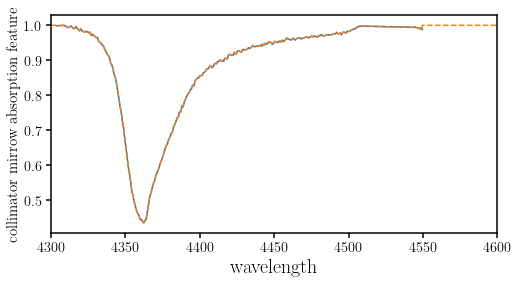

In [11]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
sub.plot(wave_absorb, fabsorb)
sub.plot(waves, fabsorb_int, ls='--')
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(4300, 4600)
sub.set_ylabel('collimator mirrow absorption feature', fontsize=15)

In [12]:
fluxes_absorb = fluxes * fabsorb_int[None,:]

(4000, 5000)

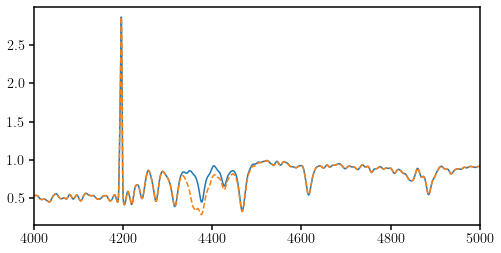

In [13]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
sub.plot(waves, fluxes[0])
sub.plot(waves, fluxes_absorb[0], ls='--')
sub.set_xlim(4000, 5000)

Now lets run it through a fiducial instrument + atmosphere model

In [14]:
dir_dat = os.path.join(UT.dat_dir(), 'srp')
fexps       = h5py.File(os.path.join(dir_dat, 'exposures_surveysim_fork_150sv0p5.sample.seed0.hdf5'), 'r')
texp        = fexps['texp_total'][...]
airmass     = fexps['airmass'][...]
moon_ill    = fexps['moon_ill'][...]
moon_alt    = fexps['moon_alt'][...]
moon_sep    = fexps['moon_sep'][...]
sun_alt     = fexps['sun_alt'][...]
sun_sep     = fexps['sun_sep'][...]
seeing      = fexps['seeing'][...]
transp      = fexps['transp'][...]

n_sample    = len(airmass) 

# read in sky brightness 
wave_sky    = fexps['wave'][...]
u_sb        = 1e-17 * u.erg / u.angstrom / u.arcsec**2 / u.cm**2 / u.second
sky_sbright = fexps['sky'][...]

iexp = 0 
print('t_exp = %.f' % texp[iexp])
print('airmass = %.2f' % airmass[iexp])
print('moon_ill = %.2f' % moon_ill[iexp])
print('moon_alt = %.2f' % moon_alt[iexp])
print('moon_sep = %.2f' % moon_sep[iexp])
print('sun_alt = %.2f' % sun_alt[iexp])
print('sun_sep = %.2f' % sun_sep[iexp])
print('seeing = %.2f' % seeing[iexp])

# iexp-th sky spectra 
Isky = [wave_sky, sky_sbright[iexp]]

t_exp = 540
airmass = 1.01
moon_ill = 0.70
moon_alt = 39.55
moon_sep = 55.63
sun_alt = -18.77
sun_sep = 111.50
seeing = 0.79


In [15]:
fspec = os.path.join(UT.dat_dir(), 'ncr', 'bgs_0.08z0.14.fits')
fspec_absorb = os.path.join(UT.dat_dir(), 'ncr', 'bgs_0.08z0.14_absorb.fits')

In [16]:
# simulate the exposures 
fdesi = FM.fakeDESIspec()

bgs = fdesi.simExposure(waves, fluxes, exptime=texp[iexp], airmass=airmass[iexp], Isky=Isky, filename=fspec) 
bgs_absorb = fdesi.simExposure(waves, fluxes_absorb, exptime=texp[iexp], airmass=airmass[iexp], Isky=Isky, filename=fspec_absorb) 

/anaconda2/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/anaconda2/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


(0.0, 1.2)

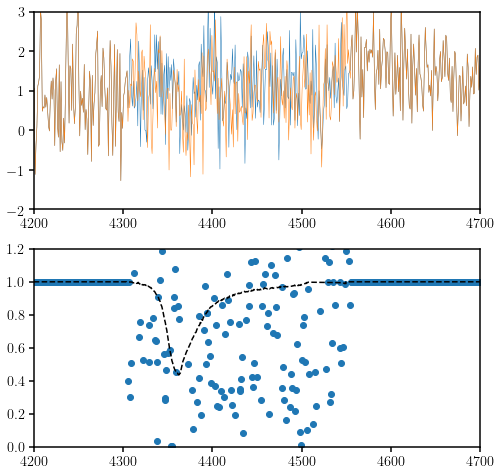

In [17]:
fig = plt.figure(figsize=(8,8))
sub = fig.add_subplot(211)
for band in ['b', 'r', 'z']:
    sub.plot(bgs.wave[band], bgs.flux[band][1], c='C0', lw=0.5)
    sub.plot(bgs_absorb.wave[band], bgs_absorb.flux[band][1], c='C1', lw=0.5)
sub.set_xlim(4200, 4700)
sub.set_ylim(-2, 3)

sub = fig.add_subplot(212)
for band in ['b']:#, 'r', 'z']:
    sub.scatter(bgs.wave[band], bgs_absorb.flux[band][1]/bgs.flux[band][1], c='C0')#, lw=0.5)
sub.plot(waves, fabsorb_int, c='k', ls='--')
sub.set_xlim(4200, 4700)
sub.set_ylim(0., 1.2)

In [18]:
fredr_absorb = fspec_absorb.replace('.fits', '.rr.fits')
fzout_absorb = fspec_absorb.replace('.fits', '.rr.h5')
cmd_absorb = "rrdesi --mp 2 --zbest %s --output %s %s" % (fredr_absorb, fzout_absorb, fspec_absorb) # run on command line 
print(cmd_absorb)

rrdesi --mp 2 --zbest /Users/ChangHoon/data/feasiBGS/ncr/bgs_0.08z0.14_absorb.rr.fits --output /Users/ChangHoon/data/feasiBGS/ncr/bgs_0.08z0.14_absorb.rr.h5 /Users/ChangHoon/data/feasiBGS/ncr/bgs_0.08z0.14_absorb.fits


In [19]:
fredr = fspec.replace('.fits', '.rr.fits')
fzout = fspec.replace('.fits', '.rr.h5')
cmd = "rrdesi --mp 2 --zbest %s --output %s %s" % (fredr, fzout, fspec) # run on command line 
print(cmd)

rrdesi --mp 2 --zbest /Users/ChangHoon/data/feasiBGS/ncr/bgs_0.08z0.14.rr.fits --output /Users/ChangHoon/data/feasiBGS/ncr/bgs_0.08z0.14.rr.h5 /Users/ChangHoon/data/feasiBGS/ncr/bgs_0.08z0.14.fits


read in redrock outputs and calculate redshift success rate

In [20]:
from astropy.io import fits

In [21]:
RR_absorb = fits.open(fredr_absorb)[1].data
z_rr_absorb = RR_absorb['Z']
dchi2_absorb = RR_absorb['DELTACHI2']
z_warn_absorb = RR_absorb['ZWARN']

RR = fits.open(fredr)[1].data
z_rr = RR['Z']
dchi2 = RR['DELTACHI2']
z_warn = RR['ZWARN']

In [22]:
# redshift success 
zsuccess_absorb = UT.zsuccess(z_rr_absorb, redshift[igal], z_warn_absorb, deltachi2=dchi2_absorb, min_deltachi2=40.)
zsuccess = UT.zsuccess(z_rr, redshift[igal], z_warn, deltachi2=dchi2, min_deltachi2=40.) 

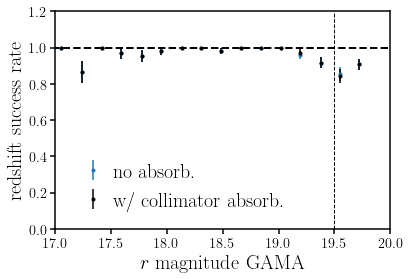

In [24]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([15., 22.], [1., 1.], c='k', ls='--', lw=2)
wmean, rate, err_rate = UT.zsuccess_rate(r_mag_gama[igal], zsuccess, range=[15,20], nbins=28, bin_min=10) 
sub.errorbar(wmean, rate, err_rate, fmt='.C0', label='no absorb.')
wmean, rate, err_rate = UT.zsuccess_rate(r_mag_gama[igal], zsuccess_absorb, range=[15,20], nbins=28, bin_min=10) 
sub.errorbar(wmean, rate, err_rate, fmt='.k', label='w/ collimator absorb.')
sub.vlines(19.5, 0., 1.2, color='k', linestyle='--', linewidth=1)
sub.set_xlabel(r'$r$ magnitude GAMA', fontsize=20)
sub.set_xlim([17., 20.]) 
sub.set_ylabel(r'redshift success rate', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower left', handletextpad=0., prop={'size': 20})